In [1]:
import sys
sys.path.append('../')

from app.data import Database

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from scipy.stats import ttest_ind

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

In [3]:
df = Database().dataframe()
df.head()

,Name,Type,Level,Rarity,Damage,Health,Energy,Sanity,Timestamp
0,Hell Hound,Demonic,2,Rank 1,2d4+3,8.46,7.82,9.70,2023-05-05 10:18:35
1,Wyvern,Dragon,10,Rank 3,10d8,76.09,83.98,81.89,2023-05-05 10:18:35
2,Blue Faerie,Fey,10,Rank 0,10d2+1,19.30,20.55,20.97,2023-05-05 10:18:35
3,Kobold Villager,Devilkin,8,Rank 5,8d12+1,100.00,97.54,95.83,2023-05-05 10:18:35
4,Faerie Dragon,Dragon,19,Rank 0,19d2+1,38.01,37.87,37.11,2023-05-05 10:18:35


In [4]:
df['Rank'] = df['Rarity'].apply(lambda x: x[-1]).astype(int)

In [5]:
df.head()

,Name,Type,Level,Rarity,Damage,Health,Energy,Sanity,Timestamp,Rank
0,Hell Hound,Demonic,2,Rank 1,2d4+3,8.46,7.82,9.70,2023-05-05 10:18:35,1
1,Wyvern,Dragon,10,Rank 3,10d8,76.09,83.98,81.89,2023-05-05 10:18:35,3
2,Blue Faerie,Fey,10,Rank 0,10d2+1,19.30,20.55,20.97,2023-05-05 10:18:35,0
3,Kobold Villager,Devilkin,8,Rank 5,8d12+1,100.00,97.54,95.83,2023-05-05 10:18:35,5
4,Faerie Dragon,Dragon,19,Rank 0,19d2+1,38.01,37.87,37.11,2023-05-05 10:18:35,0


In [6]:
features = ['Level', 'Health', 'Energy', 'Sanity']
target = ['Rank']

X_whole = df[features]
y_whole = df[target]

X, X_test, y, y_test = train_test_split(X_whole, y_whole, test_size=0.2, random_state=0)

In [7]:
y_test.value_counts()

Rank
0       255
1       210
2       132
3       132
4        72
5        19
Name: count, dtype: int64

The data is unbalanced. Although due to the linearity of the data, that may not be a huge concern.

I will first see what can be achieved with the data before considering ways to account for the smaller sample sizes.

### Plot evaluation

In [8]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_classification(X, y, clf):
    pass

# Decision Tree

In [9]:
dtc = DecisionTreeClassifier(random_state=0)

In [10]:
dtc_score = cross_val_score(dtc, X, y.values.ravel(), cv=5,
                            scoring='f1_weighted')
sorted(dtc_score)

[0.9554451866228291,
 0.9608596278718132,
 0.963318380056933,
 0.9633235679193077,
 0.9633308557014039]

# Random Forest

In [11]:
rfc = RandomForestClassifier(random_state=0)

In [12]:
rfc_score = cross_val_score(rfc, X, y.values.ravel(), cv=5,
                            scoring='f1_weighted')
sorted(rfc_score)

[0.9812165073037936,
 0.9814352607358269,
 0.9831689360882377,
 0.9875303561260816,
 0.987684683464149]

# AdaBoost

In [73]:
abc = AdaBoostClassifier(random_state=0, n_estimators=500)

In [74]:
abc_score = cross_val_score(abc, X, y.values.ravel(), cv=5,
                            scoring='f1_weighted', n_jobs=-1)
sorted(abc_score)

[0.27886545588313966,
 0.2877632817598302,
 0.3120287008146338,
 0.32516398103507915,
 0.32872233200941825]

# XGBoost

In [15]:
xgbc = XGBClassifier(random_state=0, objective='multi:softmax')

In [16]:
xgbc_score = cross_val_score(xgbc, X, y.values.ravel(), cv=5,
                             scoring='f1_weighted')
sorted(xgbc_score)

[0.9685561349130367,
 0.978328320059157,
 0.9784464924400532,
 0.9799080216903574,
 0.9801441834164856]

## SVM

In [93]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

svc = Pipeline(steps=[
    ("scalar", StandardScaler()),
    ("svc", LinearSVC(multi_class='crammer_singer',
                      random_state=0,
                      max_iter=1_000_000_000,
                      penalty='l2'))
                      ])

In [94]:
svc_score = cross_val_score(svc, X, y.values.ravel(), cv=5,
                            scoring='f1_weighted')
sorted(svc_score)

/home/levi/.local/share/virtualenvs/BandersnatchStarter-H27bAAec/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/levi/.local/share/virtualenvs/BandersnatchStarter-H27bAAec/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/levi/.local/share/virtualenvs/BandersnatchStarter-H27bAAec/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/levi/.local/share/virtualenvs/BandersnatchStarter-H27bAAec/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/levi/.local/share/virtualenvs/BandersnatchStarter-H27bAAec/lib/python3.10/site-packages/sklearn/svm/_b

[0.9391961075605612,
 0.9517623230047312,
 0.9582629317103315,
 0.9623160178275627,
 0.9657026851071524]

## Nearest Neigbor

In [68]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier(weights='distance', algorithm='auto',
                           n_jobs=-1, leaf_size=2)

In [69]:
knc_score = cross_val_score(knc, X, y.values.ravel(), cv=5,
                            scoring='f1_weighted', n_jobs=-1)
sorted(knc_score)

[0.8965817809060395,
 0.897261476654841,
 0.8983732365740964,
 0.901016095815205,
 0.9221869244255976]

# Baseline comparisons

<Axes: >

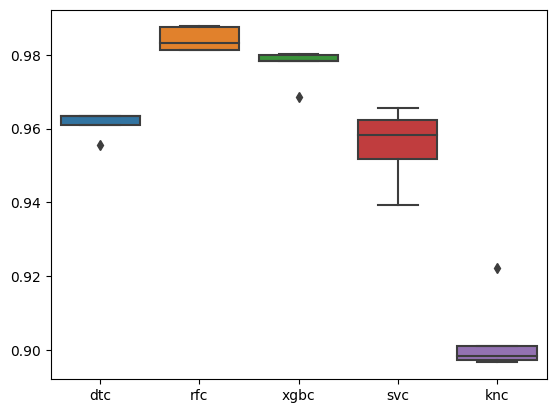

In [85]:
sns.boxplot(data=pd.DataFrame({'dtc': dtc_score,
                               'rfc': rfc_score,
                               'xgbc': xgbc_score,
                               'svc': svc_score,
                               'knc': knc_score}))

In [18]:
abc_score.max()

0.32872233200941825

The Random Forest Classifier is performing better than the other baseline considerations on average.

# Hyper-parameterization

## Decision Tree

In [19]:
grid_param = {
    'class_weight': [None, 'balanced'],
    'max_depth': [None, 20, 50, 100]
}

dtc_grid = GridSearchCV(dtc, grid_param, cv=5,
                        verbose=1, n_jobs=-1)

In [20]:
dtc_grid.fit(X, y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [None, 20, 50, 100]},
             verbose=1)

In [21]:
dtc_grid.best_score_, dtc_grid.best_params_

(0.9661189722584249, {'class_weight': 'balanced', 'max_depth': None})

## Random Forest

In [22]:
param_dict = {
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_samples_split': [2, 5],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}

rfc_random = RandomizedSearchCV(rfc, param_dict, n_iter=100, cv=5,
                                verbose=1, random_state=0, n_jobs=-1)

In [23]:
rfc_random.fit(X, y.values.ravel())

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=0, verbose=1)

In [24]:
rfc_random.best_score_, rfc_random.best_params_

(0.9844330664680694,
 {'n_estimators': 200,
  'min_samples_split': 2,
  'min_samples_leaf': 1,
  'max_depth': 100})

In [25]:
grid_param = {
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2],
    'max_features': [None],
    'max_depth': [None, 100]
}

rfc_grid = GridSearchCV(rfc, grid_param, cv=5,
                        verbose=1, n_jobs=-1, scoring='f1_weighted')

In [26]:
rfc_grid.fit(X, y.values.ravel())

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [None, 100], 'max_features': [None],
                         'min_samples_split': [2],
                         'n_estimators': [100, 200, 300]},
             scoring='f1_weighted', verbose=1)

In [27]:
rfc_grid.best_score_, rfc_grid.best_params_

(0.9808383422716151,
 {'max_depth': None,
  'max_features': None,
  'min_samples_split': 2,
  'n_estimators': 300})

In [98]:
n_estimators = [100, 200, 300]
row = []

for rand in range(25):
    for n_est in n_estimators:
        rfc_test = RandomForestClassifier(n_estimators=n_est,
                                          max_features=None,
                                          random_state=rand)
        score = cross_val_score(rfc_test, X, y.values.ravel(), cv=5,
                                scoring='f1_weighted')
        
        row.append([n_est, score.mean()])
            

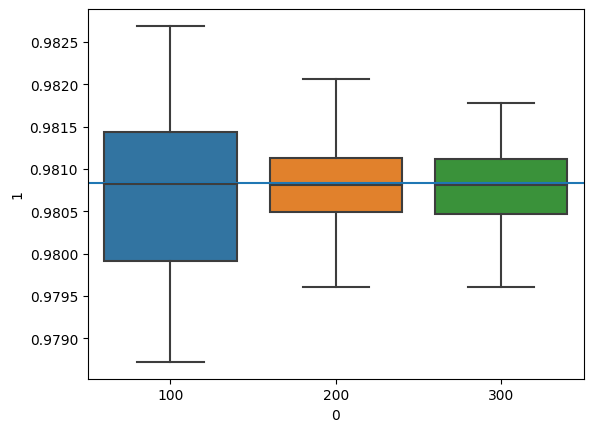

In [99]:
sns.boxplot(pd.DataFrame(row), x=0, y=1)
plt.axhline(y=rfc_grid.best_score_)

In [30]:
rfc_best = RandomForestClassifier(n_estimators=200, random_state=0, max_features=None)
rfc_best.fit(X, y)

/tmp/ipykernel_8500/1111682799.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc_best.fit(X, y)


RandomForestClassifier(max_features=None, n_estimators=200, random_state=0)

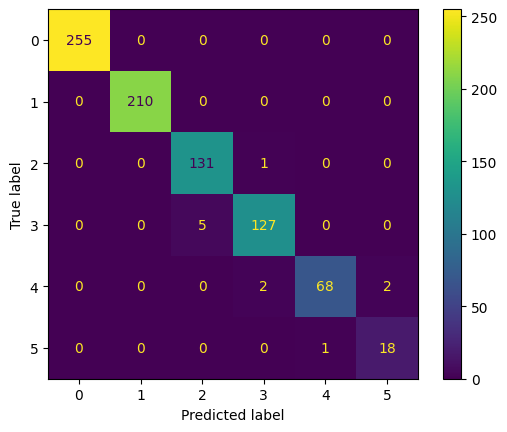

In [31]:
ConfusionMatrixDisplay.from_estimator(rfc_best, X_test, y_test)

In [32]:
df_rfc = pd.merge(X_test, y_test, how='left', left_index=True, right_index=True)
df_rfc['Pred'] = rfc_best.predict(X_test)
df_rfc.loc[df_rfc['Pred'] != df_rfc['Rank']]

,Level,Health,Energy,Sanity,Rank,Pred
1772,1,6.72,6.28,10.45,3,2
1887,1,6.58,6.60,5.55,3,2
2100,4,41.12,43.44,38.49,4,5
2030,2,12.27,13.75,13.67,3,2
124,3,26.68,27.94,26.09,4,3
1590,2,19.85,20.89,18.14,5,4
977,4,36.83,44.51,42.58,4,5
4021,1,9.48,6.94,6.25,4,3
188,2,13.30,12.49,15.24,3,2
1620,2,13.64,12.27,13.02,2,3


## XGBoost

In [33]:
param_dict = {
    'n_estimators': [50, 75, 100, 125, 150],
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [2, 3, 4]
}

xgbc_grid = GridSearchCV(xgbc, param_dict, cv=5,
                         verbose=1, n_jobs=-1)

In [34]:
xgbc_grid.fit(X, y)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='multi:softmax', predictor=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [2, 3, 4],
                         'n_estimators': [50, 75, 100, 125, 150]},
             verbose=1)

In [35]:
xgbc_grid.best_score_, xgbc_grid.best_params_

(0.9783285235524112,
 {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 100})

In [39]:
param_dict = {
    'n_estimators': [80, 90, 100],
    'learning_rate': [0.2, 0.3, 0.4, 0.5],
    'max_depth': [3, 4, 5]
}

xgbc_grid = GridSearchCV(xgbc, param_dict, cv=5,
                         verbose=1, n_jobs=-1)

In [40]:
xgbc_grid.fit(X, y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='multi:softmax', predictor=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.3, 0.4, 0.5],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [80, 90, 100]},
             verbose=1)

In [41]:
xgbc_grid.best_score_, xgbc_grid.best_params_

(0.9795494321355427,
 {'learning_rate': 0.4, 'max_depth': 4, 'n_estimators': 90})

In [42]:
xgbc_best = xgbc_grid.best_estimator_

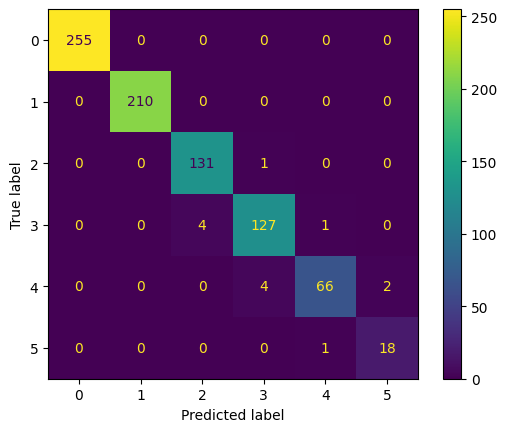

In [43]:
ConfusionMatrixDisplay.from_estimator(xgbc_best, X_test, y_test)

In [46]:
df_xgbc = pd.merge(X_test, y_test, how='left', left_index=True, right_index=True)
df_xgbc['Pred'] = xgbc_best.predict(X_test)
df_xgbc.loc[df_xgbc['Pred'] != df_xgbc['Rank']]

,Level,Health,Energy,Sanity,Rank,Pred
2137,1,7.07,8.30,10.02,3,2
2838,1,6.86,11.86,9.54,4,3
1772,1,6.72,6.28,10.45,3,2
1887,1,6.58,6.60,5.55,3,2
2100,4,41.12,43.44,38.49,4,5
2030,2,12.27,13.75,13.67,3,2
1669,20,159.52,163.22,162.27,3,4
124,3,26.68,27.94,26.09,4,3
548,3,27.46,26.56,31.22,4,3
1590,2,19.85,20.89,18.14,5,4


# Support Vector Machine

In [86]:
param_dict = {
    'svc__penalty': ['l1', 'l2'],
    'svc__multi_class': ['ovr', 'crammer_singer'],
    'svc__class_weight': [None, 'balanced']
}

svc_grid = GridSearchCV(svc, param_dict, cv=5, verbose=1, n_jobs=-1)

In [87]:
svc_grid.fit(X, y.values.ravel())

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/home/levi/.local/share/virtualenvs/BandersnatchStarter-H27bAAec/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/levi/.local/share/virtualenvs/BandersnatchStarter-H27bAAec/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/levi/.local/share/virtualenvs/BandersnatchStarter-H27bAAec/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/levi/.local/share/virtualenvs/BandersnatchStarter-H27bAAec/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debu

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('svc',
                                        LinearSVC(max_iter=1000000000,
                                                  multi_class='crammer_singer',
                                                  random_state=0))]),
             n_jobs=-1,
             param_grid={'svc__class_weight': [None, 'balanced'],
                         'svc__multi_class': ['ovr', 'crammer_singer'],
                         'svc__penalty': ['l1', 'l2']},
             verbose=1)

In [88]:
svc_grid.best_score_, svc_grid.best_params_

(0.9563484453546826,
 {'svc__class_weight': None,
  'svc__multi_class': 'crammer_singer',
  'svc__penalty': 'l1'})

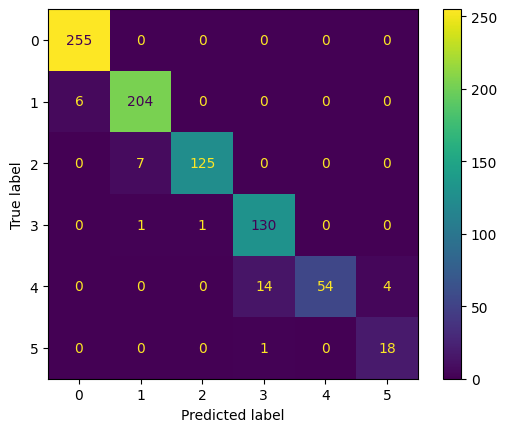

In [96]:
ConfusionMatrixDisplay.from_estimator(svc_grid.best_estimator_, X_test, y_test)

# Linear Guess

In [134]:
import numpy as np

def guesser(level, power) -> np.ndarray:
    ranks = [0, 1, 2, 3, 4, 5]
    stds = [0.340, 0.614, 0.836, 1.26, 1.91, 2.27]
    z_scores = []

    for i in range(len(ranks)):
        mid = 2 * level * (ranks[i] + 1)
        z_score = abs(mid - power) / stds[i]
        z_scores.append(z_score)

    return np.array(z_scores)

def predict(X: pd.DataFrame) -> np.ndarray:
    y = []

    for i in range(len(X)):
        level = X['Level'][i]
        power = X['Power'][i]

        z_scores = guesser(level, power)

        pred_rank = z_scores.argmin()
        y.append(pred_rank)
    
    return y

In [135]:
X_index = X_test.reset_index()
X_index['Power'] = (X_index['Health'] + X_index['Energy'] + X_index['Sanity']) / 3.

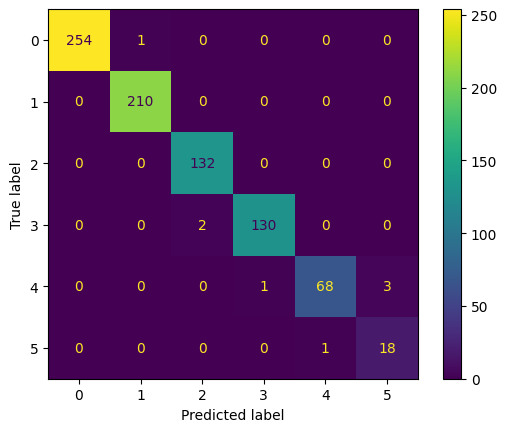

In [138]:
ConfusionMatrixDisplay.from_predictions(y_test, predict(X_index))

# Conclusion

The Random Forest Classifier easily performed the best out of the several classifiers tested. No real benefits were seen when using more competitively taxing methods in the case of XGBoost, and LinearSVM when it successfully converged.